Importing modules and functions

In [21]:
from pandas import read_csv, DataFrame, concat
from matplotlib.pyplot import *
from numpy import *

Data reading and cleaning

In [22]:
D = read_csv('Men.csv')
Dw = read_csv('Wimbledon-men-2013.csv')
D = concat([D,Dw],ignore_index=True)
StrC = ["Player1","Player2","FNL1","FNL2"]
BC = ["ST1.1","ST2.1","ST3.1","ST4.1","ST5.1","ST1.2","ST2.2","ST3.2","ST4.2","ST5.2","NPW.1","TPW.1","NPW.2","TPW.2"]
redundant = ['SSP.1','SSP.2']
D = D.drop(StrC+BC+redundant,axis=1)
null_percentage = D.isna().sum()/D.shape[0]*100
col_to_drop = null_percentage[null_percentage>50].keys()
D = D.drop(col_to_drop, axis=1)
D = D.dropna(axis=0)
'''
BinC = []
for bc in BC :
    if bc not in col_to_drop :
        BinC.append(bc)
Xb = (D.loc[:,BinC]).to_numpy()
D = D.drop(BinC,axis=1)
'''
y = D["Result"].to_numpy()
D = D.drop("Result",axis=1)
X = D.to_numpy()
X.shape,y.shape #,Xb.shape

((339, 21), (339,))

In [23]:
def Kfold(clf,X,y,k=0):
    ''' K fold cross validation. Here k = n, which actually makes it LOOCV '''
    n = len(X)
    S = 0
    if(k==0):
        k = len(X)
    for i in range(k):
        X_test =X[i*n//k:(i+1)*n//k,:]
        y_test =y[i*n//k:(i+1)*n//k]
        X_train =  concatenate((X[:i*n//k,:],X[(i+1)*n//k:,:]))
        y_train =  concatenate((y[:i*n//k],y[(i+1)*n//k:]))
        S += 100* mean(clf(X_train,y_train)(X_test) == y_test)
    return S/k

Guassian Naive Bayes Classifier Algorithm

In [24]:
def NB(X,y,k=2,Xb=[]):
    #Although I am not passing binary data, I have extended the algorithm to use binary data too, in case it's needed in future.
    mu = []
    sig2 = []
    pb = []
    PC = []
    for c in range(k):
        clus = y==c
        PC.append(mean(clus))
        mu.append(mean(X[clus],axis=0))
        sig2.append(var(X[clus],axis=0))
        if(len(Xb)>0):
            pb.append(mean(Xb[clus],axis=0))
    mu = array(mu)
    sig2 = array(sig2)
    pb = array(pb)
    PC = array(PC)
    def guess(x,xb=[]):
        nonlocal mu,sig2,pb,PC
        if(len(x.shape)==2):
            x = x[:,newaxis,:]
        if(len(xb)>0 and len(xb.shape)==2):
            xb = xb[:,newaxis,:]
        p = exp(- square(x-mu) / (2*sig2))/sqrt(2*pi*sig2)
        p = product(p,axis=-1) * PC
        if(len(xb)>0):
            p = p * product((1-pb) + (2*pb-1)*xb,axis=-1)
        return argmax(p,axis=-1)
    return guess

Principal Component Analysis Algorithm

In [25]:
def PCA(X,d,Show=False):
    mu = mean(X,axis=0)
    sd = sqrt(var(X,axis=0))
    X = (X - mu)/sd
    XT = X[:,newaxis,:]
    X = X[:,:,newaxis]
    X = X*XT
    X = mean(X,axis=0)
    lam,R = linalg.eig(X)
    idx = argsort(lam)[-1:-d-1:-1]
    M = R.T
    M = M[idx,:]
    lam = lam[idx]
    Ms = abs(lam[:,newaxis]*M)
    X = sum(M*XT,axis=-1)
    if Show:
        matshow(Ms,cmap="Reds")
        title("M")
        figure()
    else :
        return X

Linear Classifier

In [26]:
def CovS(X,y,Show=False):
    '''
    X:  data of shape (n,f) \n
    y:  binary (0 or 1) representation of results (Win or Loss for player 1). Shape: (n,) 
    '''
    Y = (2*y - 1)[:,newaxis]
    mu = mean(X,axis=0)
    d = sqrt(var(X,axis=0))
    Xs = (X - mu)/d
    cov = mean(Y*Xs,axis=0)
    if Show:
        matshow([abs(cov)],cmap="Greys")
        title("abs(cov)")
        yticks([])
        acovi = argsort(abs(cov))[::-1]
        df = DataFrame({
            "Variable":D.columns[acovi],
            "covariance":cov[acovi],
            "Index" : acovi
            })
        #print("\n cov :",cov,"\n Most important variables :",D.columns[acovi],"\n Respective covariances with Y (result) :",cov[acovi],"\n Indices :",acovi,sep='\n')
        df.index = df.Variable
        return df.iloc[:,1:]
    else :
        def C(x):
            x = (x - mu)/d
            return (sign(sum(x*cov,axis=-1))+1)/2
        return C

,covariance,Index
Variable,,
BPW.1,0.646120,8
BPW.2,-0.627855,18
BPC.2,-0.514476,19
BPC.1,0.508826,9
WNR.2,-0.328569,16
ACE.2,-0.270095,14
ACE.1,0.241339,4
WNR.1,0.225747,6
UFE.1,-0.201056,7


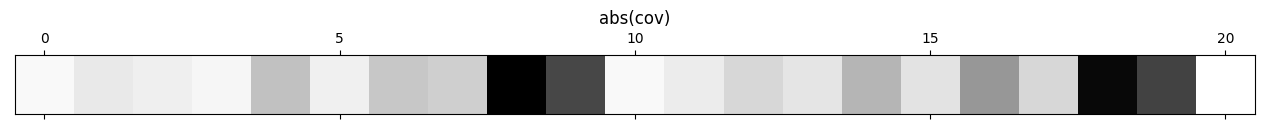

In [27]:
CovS(X,y,True)

Accuracy of Linear Classifier

In [28]:
Kfold(CovS,X,y)

92.33038348082596

Important variables

<AxesSubplot: xlabel='BPC.2', ylabel='BPC.1'>

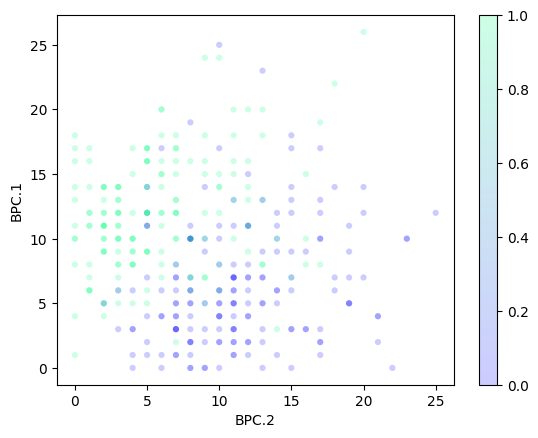

In [29]:
D.plot.scatter("BPC.2","BPC.1",c=y,alpha=0.2,linewidths=0,cmap='winter')

<AxesSubplot: xlabel='BPW.2', ylabel='BPW.1'>

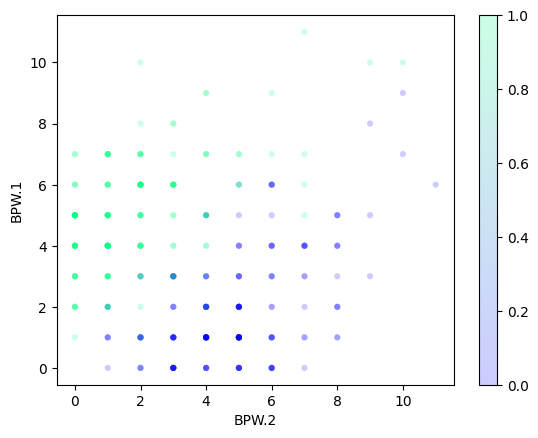

In [30]:
D.plot.scatter("BPW.2","BPW.1",c=y,alpha=0.2,linewidths=0,cmap='winter')

Dependence of BPC.1 and BPW.1

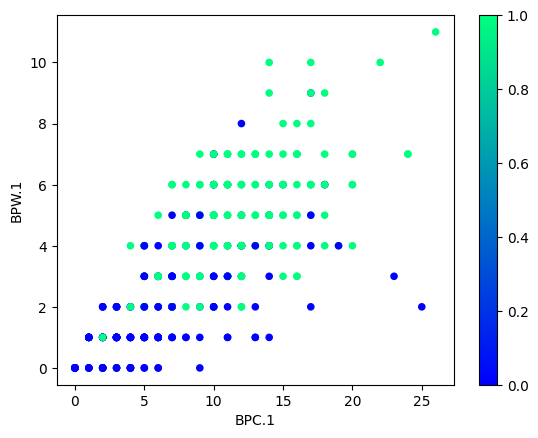

In [31]:
D.plot.scatter('BPC.1','BPW.1',c=y,cmap='winter')
show()

Covariance matrix 

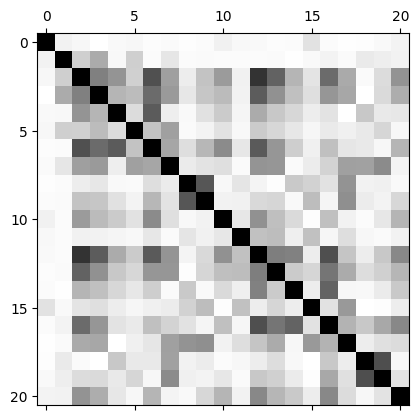

In [32]:
x = (X-mean(X,axis=0))/sqrt(var(X,axis=0))
xt = x[:,newaxis,:]
x = x[:,:,newaxis]
matshow(abs(mean(xt*x,axis=0)),cmap="Greys")

Accuracy of Guassian Naive Bayes Classifier

Without PCA

In [33]:
Kfold(NB,X,y)

91.44542772861357

results of PCA 

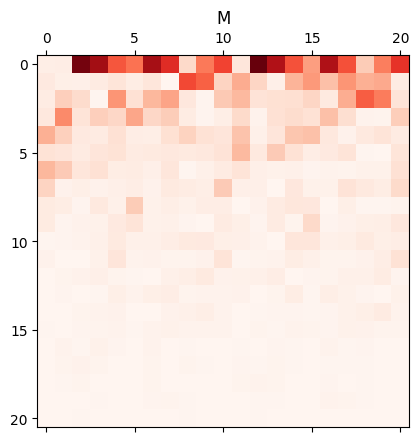

<Figure size 640x480 with 0 Axes>

In [34]:
PCA(X,len(X[0]),True)

Doing PCA

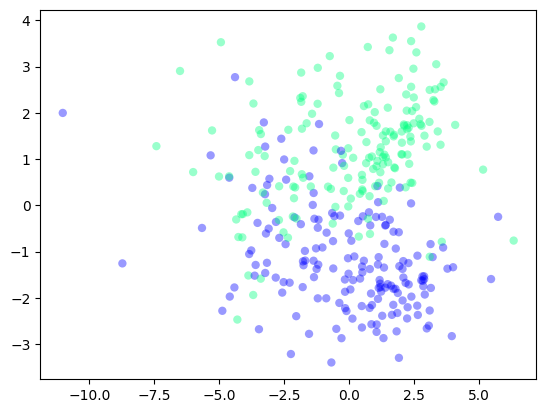

In [35]:
Xs = PCA(X,5,False)
scatter(Xs[:,0],Xs[:,1],c=y,alpha=0.4,linewidths=0,cmap='winter')
show()

Distribution of new variables

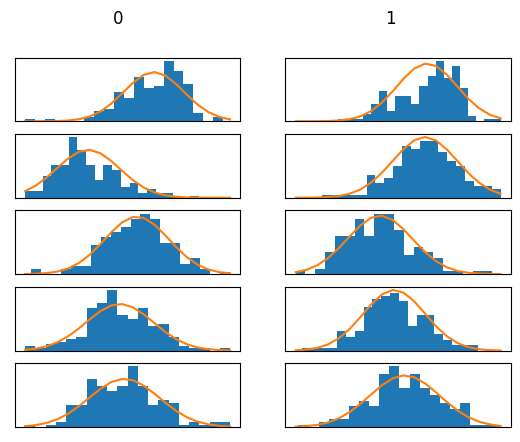

In [36]:
Bins = 20
for i in range(5):
            Xc = Xs[:,i]
            xmin = amin(Xc)
            xmax = amax(Xc)
            x = linspace(xmin,xmax,20)
            for j in range(2):
                subplot(5,2,2*i+1 + j)
                xc = Xc[y==j]
                hist(xc,Bins)
                mu = mean(xc)
                sig2 = var(xc)
                p = exp(-square(x-mu)/(2*sig2))/sqrt(2*pi*sig2)
                plot(x,p*((xmax-xmin)/Bins)*len(xc))
                xticks([])
                yticks([])
suptitle("0"+" "*50+"1")
show()

Accuracy of GNB after PCA

In [37]:
Kfold(NB,Xs,y)

91.74041297935104

Accuracy of PCA as a function of number of new variables

In [38]:
for j in range(len(X[0])):
    Xs = PCA(X,j+1,False)
    print(j+1,Kfold(NB,Xs,y))

1 49.26253687315634
2 85.84070796460178
3 90.85545722713864
4 91.15044247787611
5 91.74041297935104
6 91.74041297935104
7 91.74041297935104
8 91.44542772861357
9 90.85545722713864
10 90.85545722713864
11 90.26548672566372
12 89.97050147492625
13 91.15044247787611
14 89.97050147492625
15 90.56047197640117
16 90.56047197640117
17 90.56047197640117
18 89.6755162241888
19 91.15044247787611
20 90.56047197640117
21 90.26548672566372
